In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from drift_detectors import *
from forecasters import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Set a global seed for reproducibility
seed = 42

# Seed Python, NumPy, and PyTorch RNGs
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create and seed a PyTorch Generator (for Dataloaders)
g= torch.Generator()
g.manual_seed(seed)

# Seed CUDA (if available)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Directory paths for saving and loading components
AE_DIR = "trained_autoencoders"
FORECASTERS_DIR= "trained_forecasters"
RESULTS_DIR = "results"

# Size of the autoencoder bottleneck
latent_dim = 2

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Births", Births, None, 10),
    ("Temperatures", Temperatures, None, 10),
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["dtw", "euclidean", "cosine", "manhattan"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Training AE on Births (window_size=10)
  Epoch 1/30 — loss: 0.571796
  Epoch 2/30 — loss: 0.231702
  Epoch 3/30 — loss: 0.174073
  Epoch 4/30 — loss: 0.152278
  Epoch 5/30 — loss: 0.139907
  Epoch 6/30 — loss: 0.125528
  Epoch 7/30 — loss: 0.118537
  Epoch 8/30 — loss: 0.111724
  Epoch 9/30 — loss: 0.106928
  Epoch 10/30 — loss: 0.100778
  Epoch 11/30 — loss: 0.096188
  Epoch 12/30 — loss: 0.090173
  Epoch 13/30 — loss: 0.087915
  Epoch 14/30 — loss: 0.085979
  Epoch 15/30 — loss: 0.085935
  Epoch 16/30 — loss: 0.081218
  Epoch 17/30 — loss: 0.077968
  Epoch 18/30 — loss: 0.078351
  Epoch 19/30 — loss: 0.077987
  Epoch 20/30 — loss: 0.076120
  Epoch 21/30 — loss: 0.074405
  Epoch 22/30 — loss: 0.071303
  Epoch 23/30 — loss: 0.069087
  Epoch 24/30 — loss: 0.067591
  Epoch 25/30 — loss: 0.067371
  Epoch 26/30 — loss: 0.067508
  Epoch 27/30 — loss: 0.062982
  Epoch 28/30 — loss: 0.064403
  Epoch 29/30 — loss: 0.062352
  Epoch 30/30 — loss: 0.063719
Saved AE: trained_autoencoders\ae_Birth

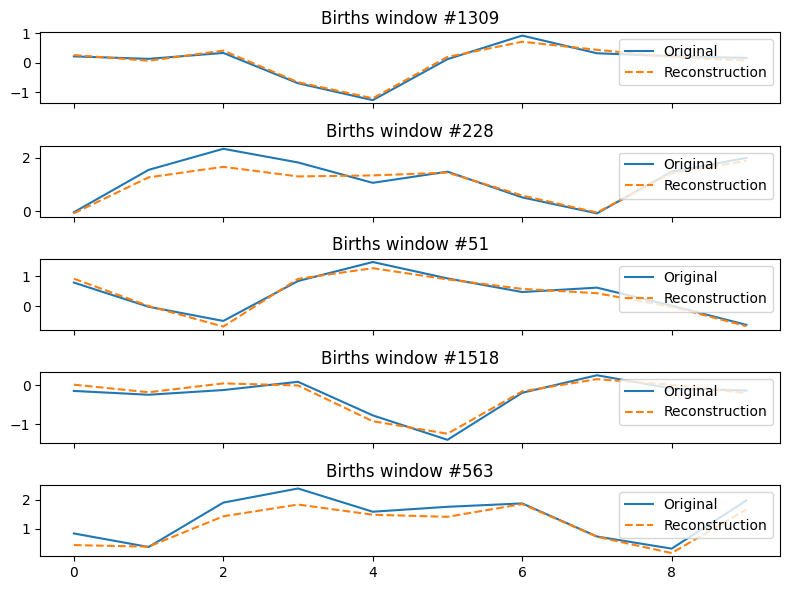


Training AE on Temperatures (window_size=10)
  Epoch 1/30 — loss: 0.731380
  Epoch 2/30 — loss: 0.287227
  Epoch 3/30 — loss: 0.231015
  Epoch 4/30 — loss: 0.206538
  Epoch 5/30 — loss: 0.193413
  Epoch 6/30 — loss: 0.176434
  Epoch 7/30 — loss: 0.167357
  Epoch 8/30 — loss: 0.160424
  Epoch 9/30 — loss: 0.149827
  Epoch 10/30 — loss: 0.143231
  Epoch 11/30 — loss: 0.136785
  Epoch 12/30 — loss: 0.132831
  Epoch 13/30 — loss: 0.133066
  Epoch 14/30 — loss: 0.126896
  Epoch 15/30 — loss: 0.117721
  Epoch 16/30 — loss: 0.113458
  Epoch 17/30 — loss: 0.111540
  Epoch 18/30 — loss: 0.112347
  Epoch 19/30 — loss: 0.109859
  Epoch 20/30 — loss: 0.105908
  Epoch 21/30 — loss: 0.104448
  Epoch 22/30 — loss: 0.102322
  Epoch 23/30 — loss: 0.103466
  Epoch 24/30 — loss: 0.096943
  Epoch 25/30 — loss: 0.099793
  Epoch 26/30 — loss: 0.097177
  Epoch 27/30 — loss: 0.097884
  Epoch 28/30 — loss: 0.095008
  Epoch 29/30 — loss: 0.099272
  Epoch 30/30 — loss: 0.096294
Saved AE: trained_autoencoders\ae

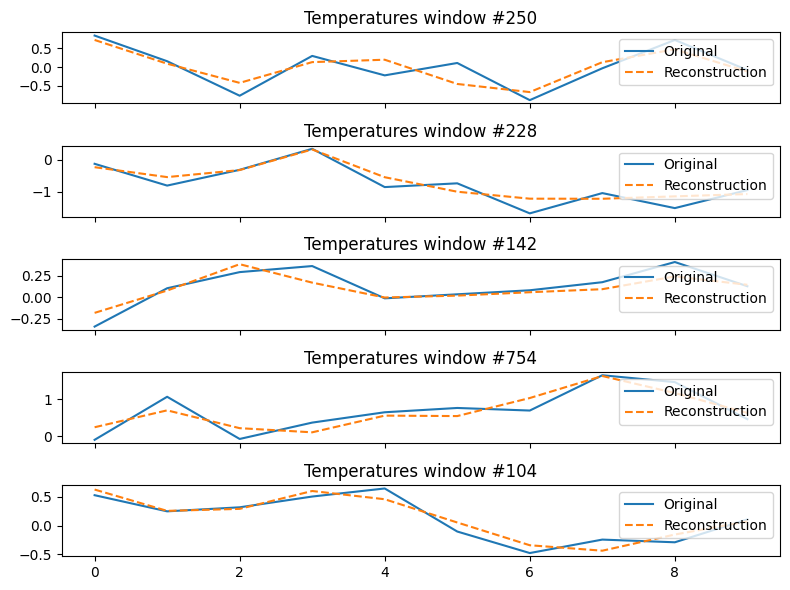

In [4]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, 
        shuffle=True, 
        generator= g
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
# Ensure a clean forecasters/ directory
if os.path.exists(FORECASTERS_DIR):
    shutil.rmtree(FORECASTERS_DIR)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(random_state=seed),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(random_state=seed),
    "DT": DecisionTreeForecaster(random_state=seed),
    "MLP1": MLPForecaster(hidden_layer_sizes=(64,), random_state=seed),
    "MLP2": MLPForecaster(hidden_layer_sizes=(64, 32), random_state=seed),
    "MLP3": MLPForecaster(hidden_layer_sizes=(128, 64, 32), random_state=seed),
    "LSTM1": LSTMForecaster(),
    "LSTM2": LSTMForecaster(num_layers=2),
    "LSTM3": LSTMForecaster(num_layers=3),
    "BiLSTM1": BiLSTMForecaster(),
    "BiLSTM2": BiLSTMForecaster(num_layers=2),
    "BiLSTM3": BiLSTMForecaster(num_layers=3),
    "CNNLSTM1": CNNLSTMForecaster(),
    "CNNLSTM2": CNNLSTMForecaster(lstm_num_layers=2),
    "CNNLSTM3": CNNLSTMForecaster(lstm_num_layers=3),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train, generator=g)

        # save the entire model object as a .pkl
        save_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Births (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP1… DONE
    → Training MLP2… DONE
    → Training MLP3… DONE
    → Training LSTM1… 1/30 0.81177 | 15/30 0.15819 | 30/30 0.10866 | DONE
    → Training LSTM2… 1/30 0.78718 | 15/30 0.17813 | 30/30 0.12333 | DONE
    → Training LSTM3… 1/30 0.77098 | 15/30 0.18110 | 30/30 0.13215 | DONE
    → Training BiLSTM1… 1/30 0.81612 | 15/30 0.15411 | 30/30 0.11383 | DONE
    → Training BiLSTM2… 1/30 0.72324 | 15/30 0.12502 | 30/30 0.10197 | DONE
    → Training BiLSTM3… 1/30 0.71629 | 15/30 0.13919 | 30/30 0.10803 | DONE
    → Training CNNLSTM1… 1/30 0.72246 | 15/30 0.12041 | 30/30 0.10073 | DONE
    → Training CNNLSTM2… 1/30 0.69843 | 15/30 0.14907 | 30/30 0.11560 | DONE
    → Training CNNLSTM3… 1/30 0.71771 | 15/30 0.16888 | 30/30 

In [6]:
os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP1",
        "MLP2",
        "MLP3",
        "LSTM1",
        "LSTM2",
        "LSTM3",
        "BiLSTM1",
        "BiLSTM2",
        "BiLSTM3",
        "CNNLSTM1",
        "CNNLSTM2",
        "CNNLSTM3",
    ]:
        pkl_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {FORECASTERS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Births (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Temperatures (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\


In [7]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Births (window_size=10) ===
RoC sizes
  ARIMA                40 entries
  ExpSmoothing         85 entries
  LinearRegression     92 entries
  RandomForest        107 entries
  SVR                 159 entries
  GradientBoosting    151 entries
  DT                  143 entries
  MLP1                117 entries
  MLP2                121 entries
  MLP3                132 entries
  LSTM1                73 entries
  LSTM2                99 entries
  LSTM3                79 entries
  BiLSTM1              51 entries
  BiLSTM2              56 entries
  BiLSTM3              51 entries
  CNNLSTM1             91 entries
  CNNLSTM2             76 entries
  CNNLSTM3             93 entries

=== Validation RoC for Temperatures (window_size=10) ===
RoC sizes
  ARIMA                94 entries
  ExpSmoothing        153 entries
  LinearRegression     16 entries
  RandomForest         22 entries
  SVR                  33 entries
  GradientBoosting     55 entries
  DT                

Bottleneck size: 2

=== Compute K-means centers for Births (window_size=10) ===


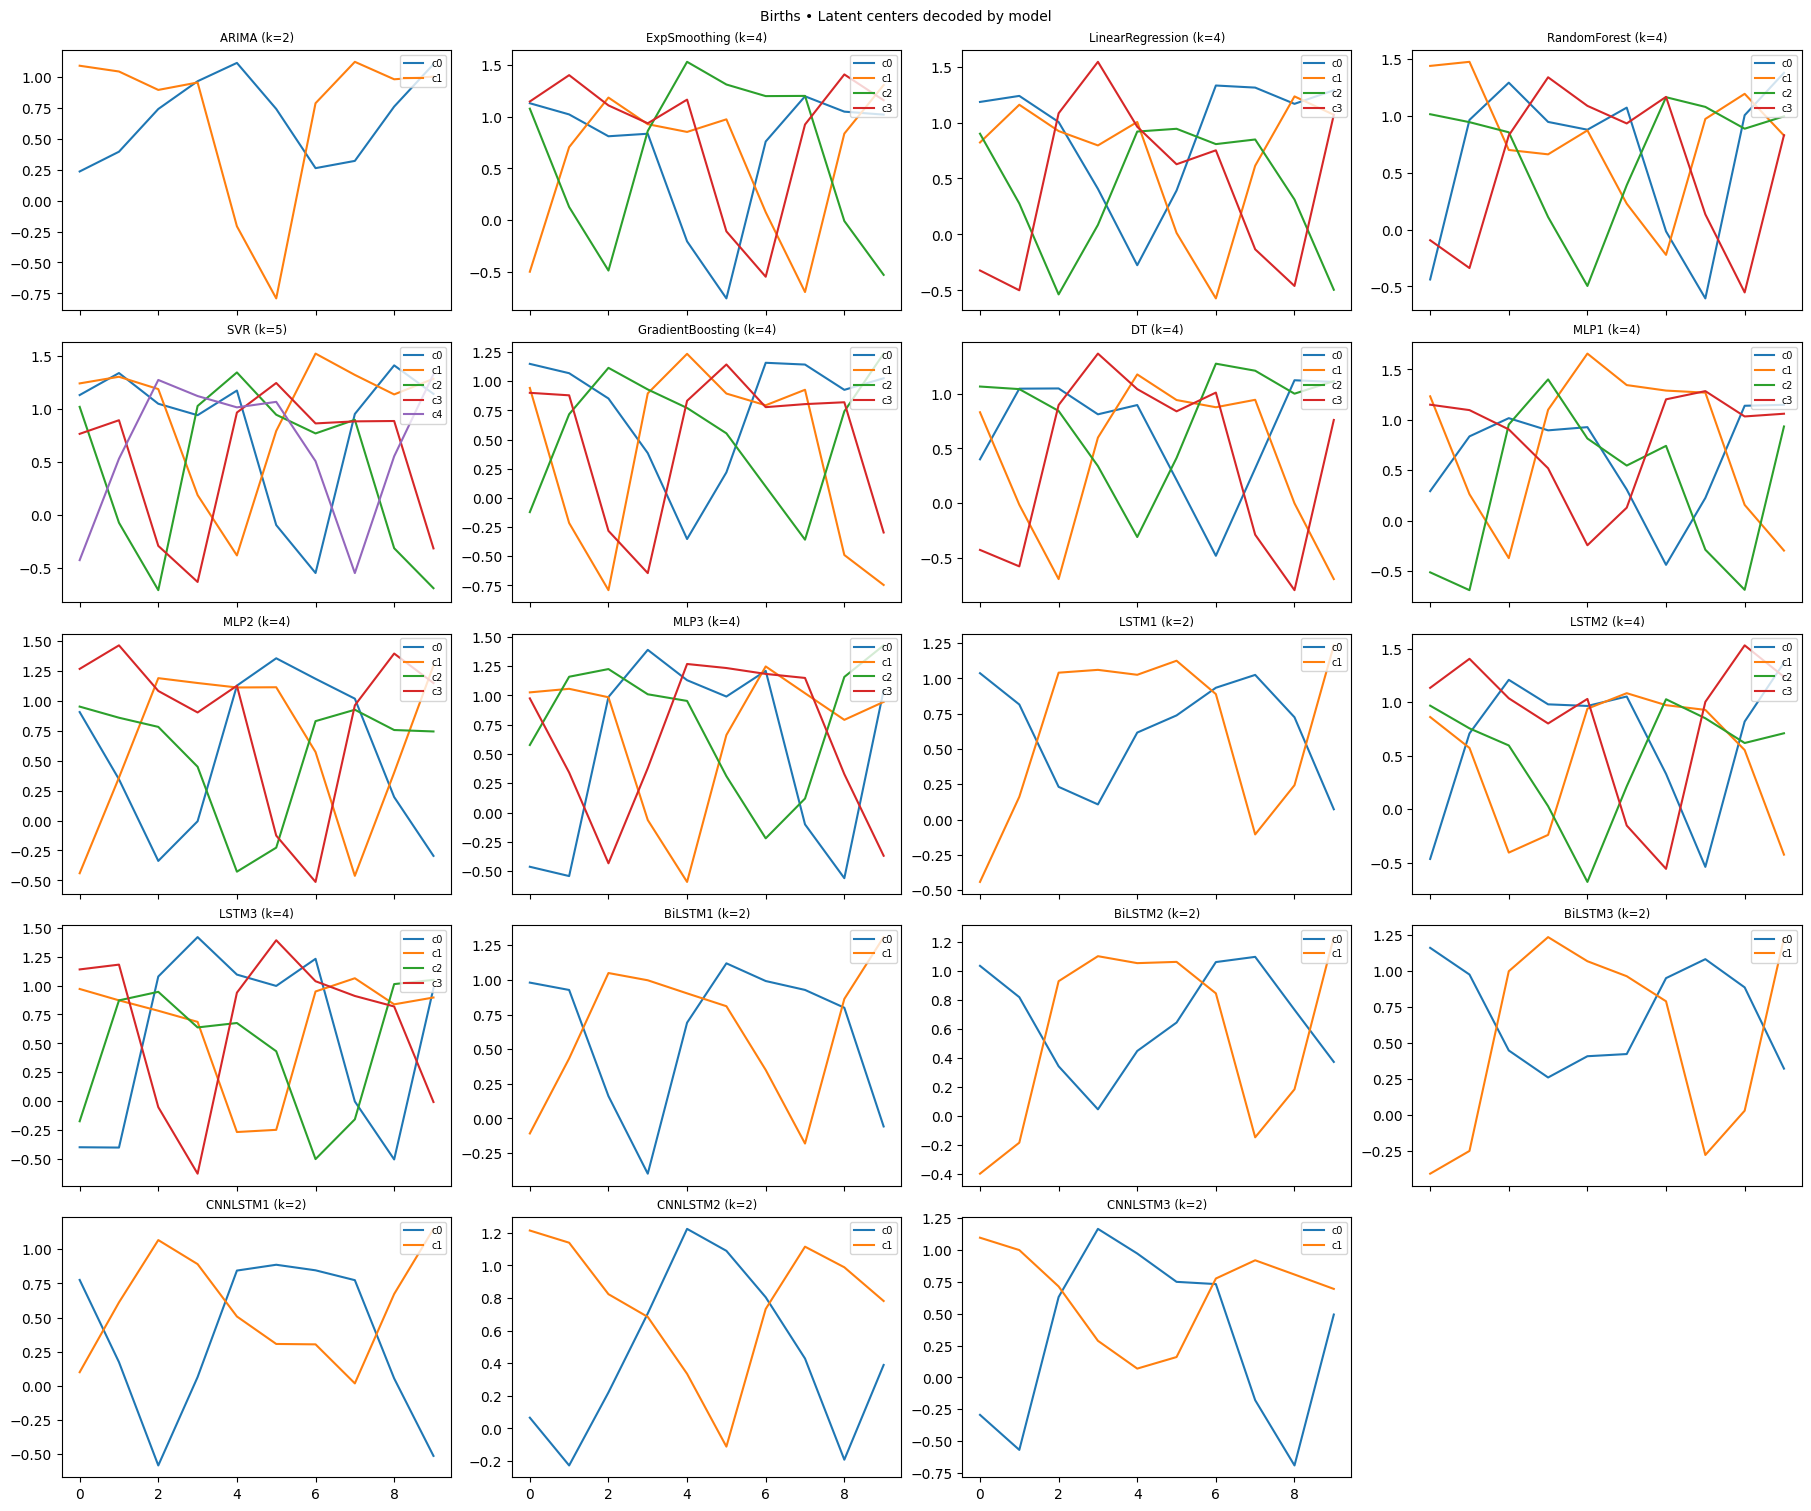


=== Compute K-means centers for Temperatures (window_size=10) ===


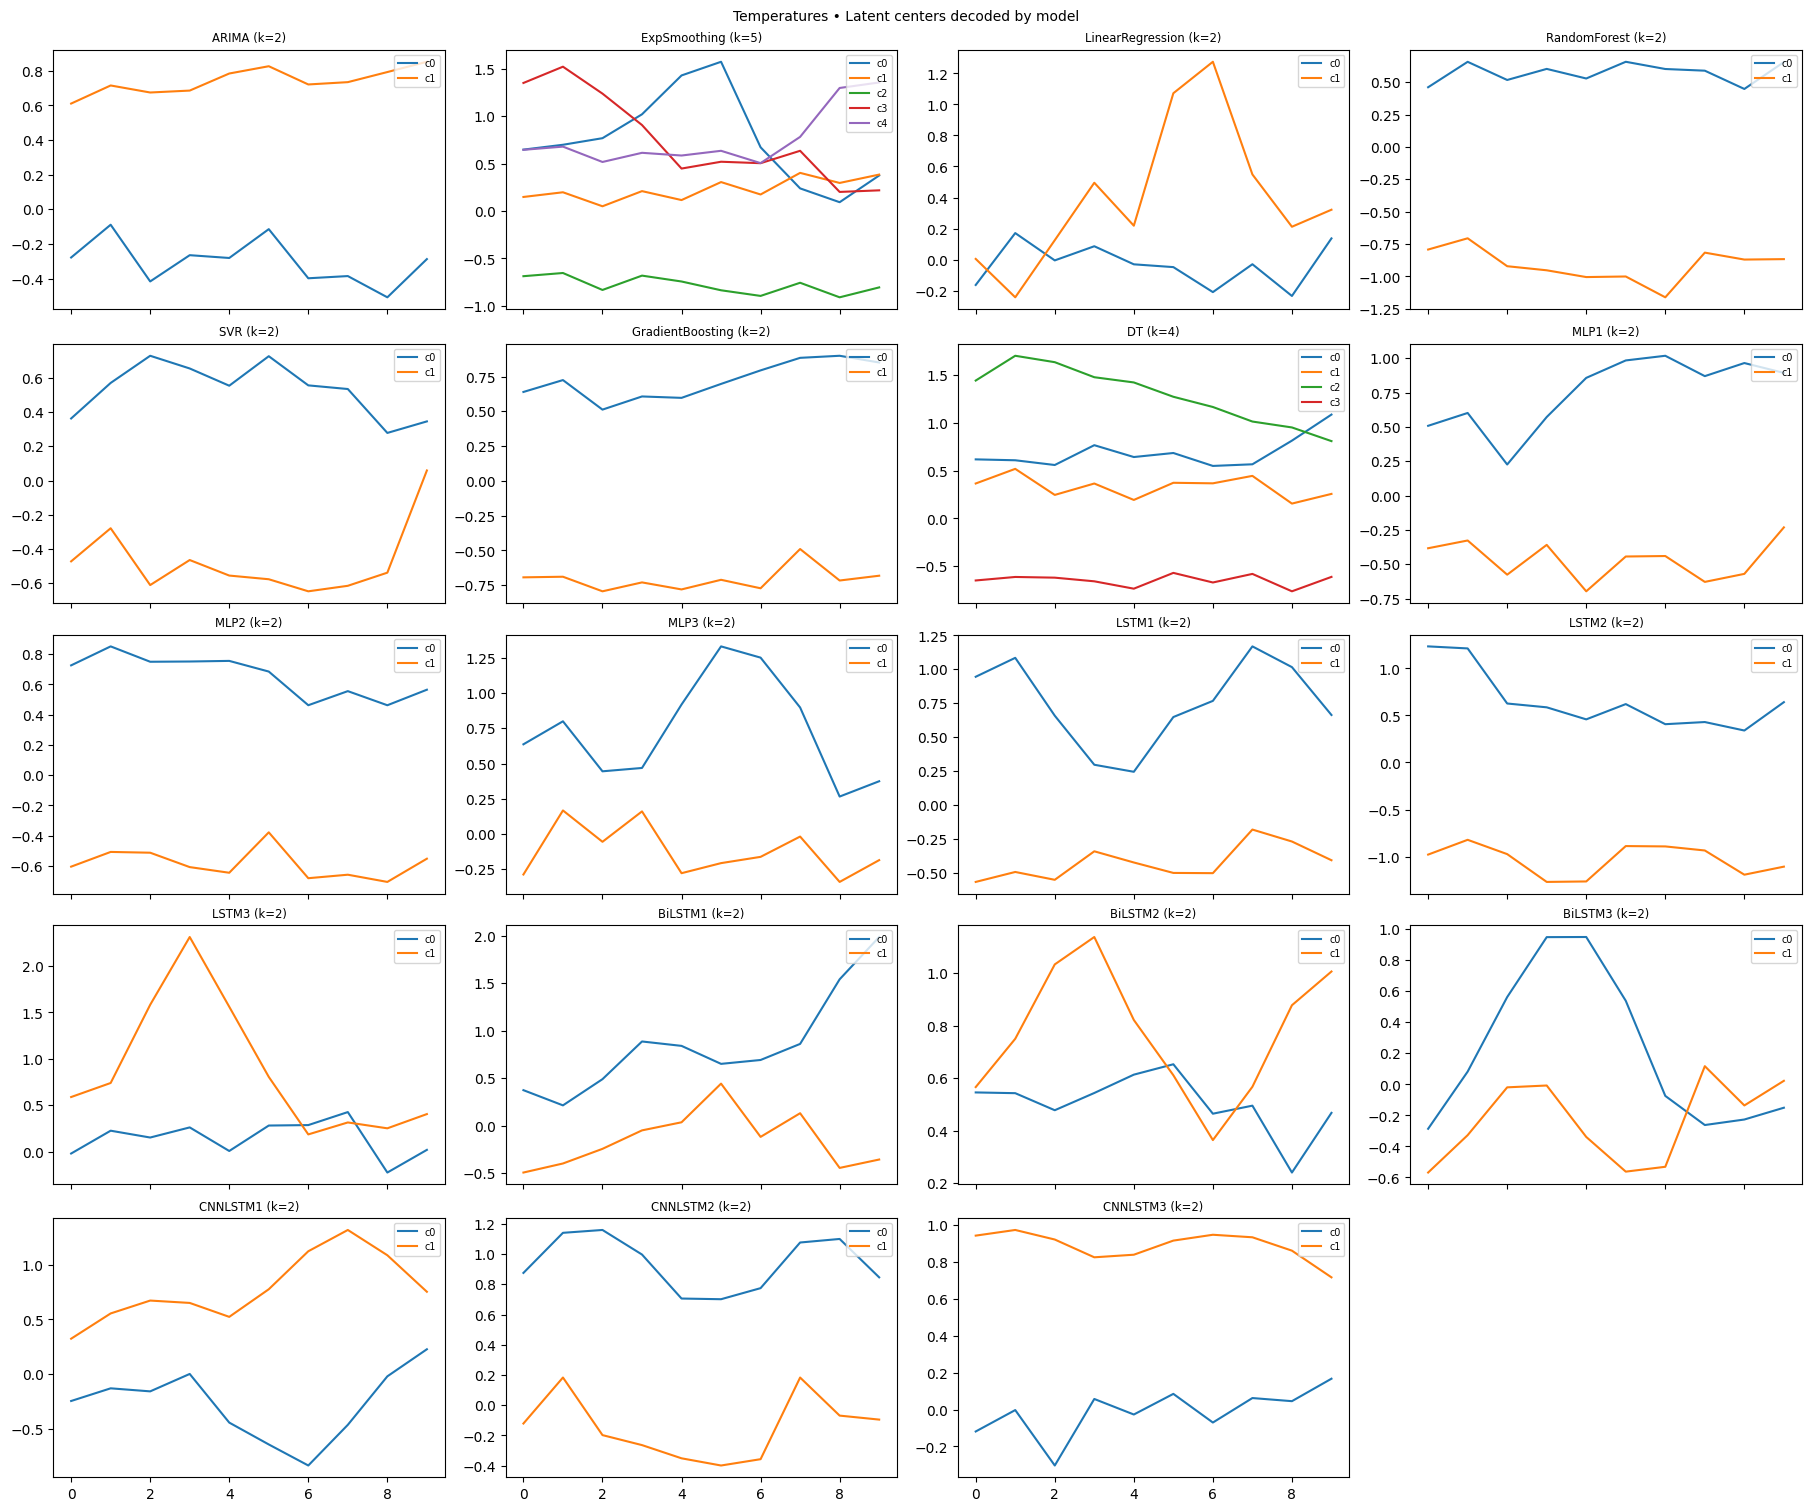

In [8]:
n_cols = 4
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous centers
    for model in forecasters.values():
        model.centers = {"raw": [], "latent": []}

    # Determine device for decoding latent centers
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # Cluster latent RoCs
        N_latent = len(model.rocs["latent"])
        if N_latent > 0:
            k_max_latent = np.sqrt(N_latent / 2)
            model.compute_kmeans_centers(mode="latent", k_max=k_max_latent, random_state=seed)

        # Cluster raw RoCs
        N_raw = len(model.rocs["raw"])
        if N_raw > 0:
            k_max_raw = np.sqrt(N_raw / 2)
            model.compute_kmeans_centers(mode="raw", k_max=k_max_raw, random_state=seed)

    # Plot all latent cluster centers (decoded)
    names = [n for n in forecasters if len(forecasters[n].centers["latent"]) > 0]
    n_models = len(names)
    if n_models == 0:
        print(" No models have centers to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers["latent"]):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers['latent'])})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()


=== Plot latent cluster samples for Births (compact grid) ===


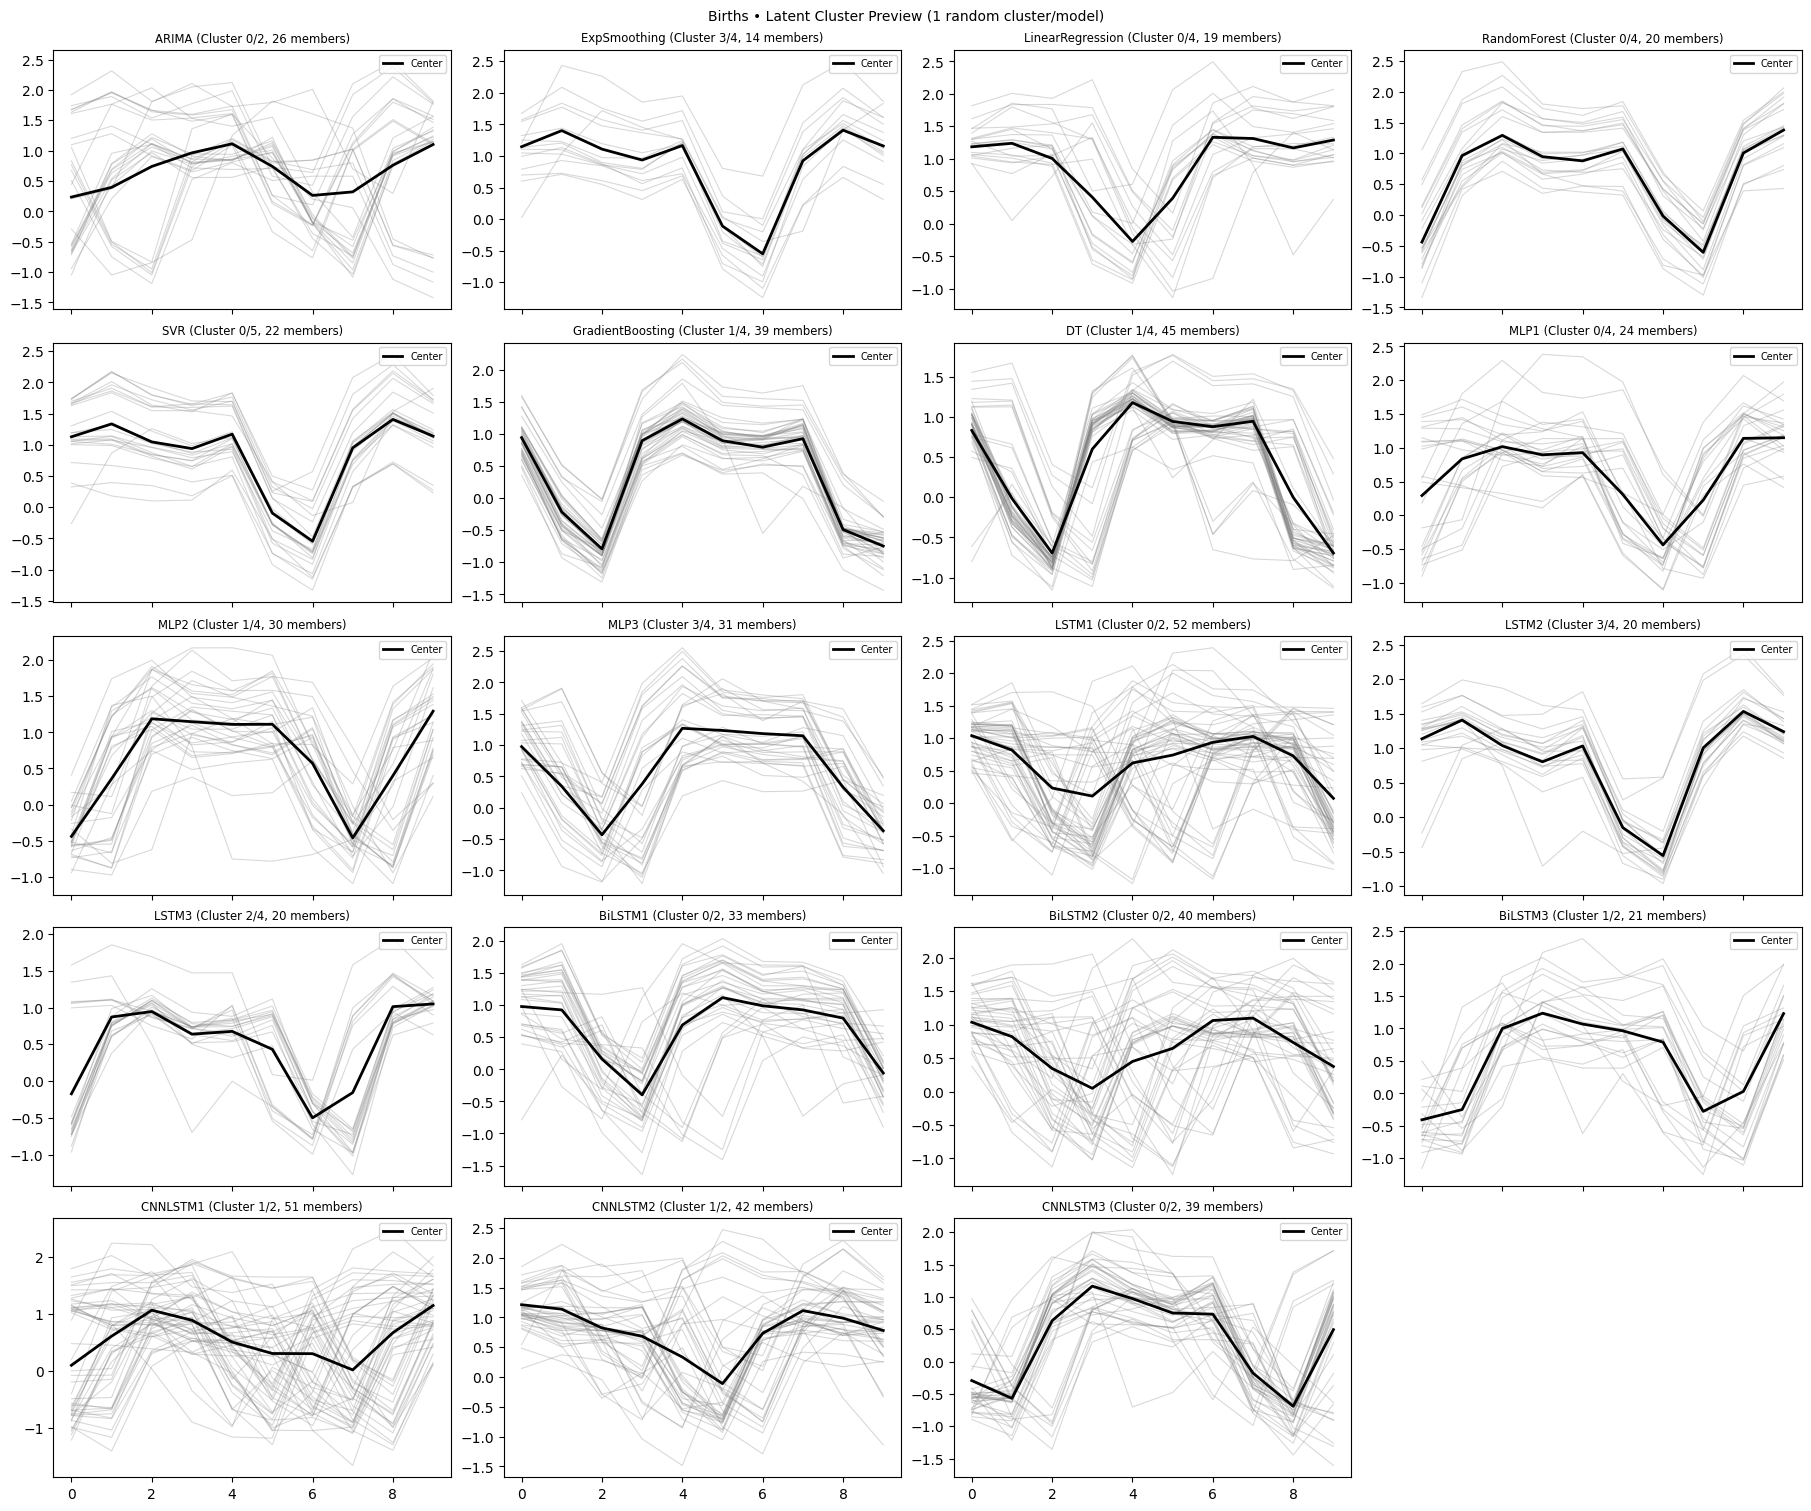


=== Plot latent cluster samples for Temperatures (compact grid) ===


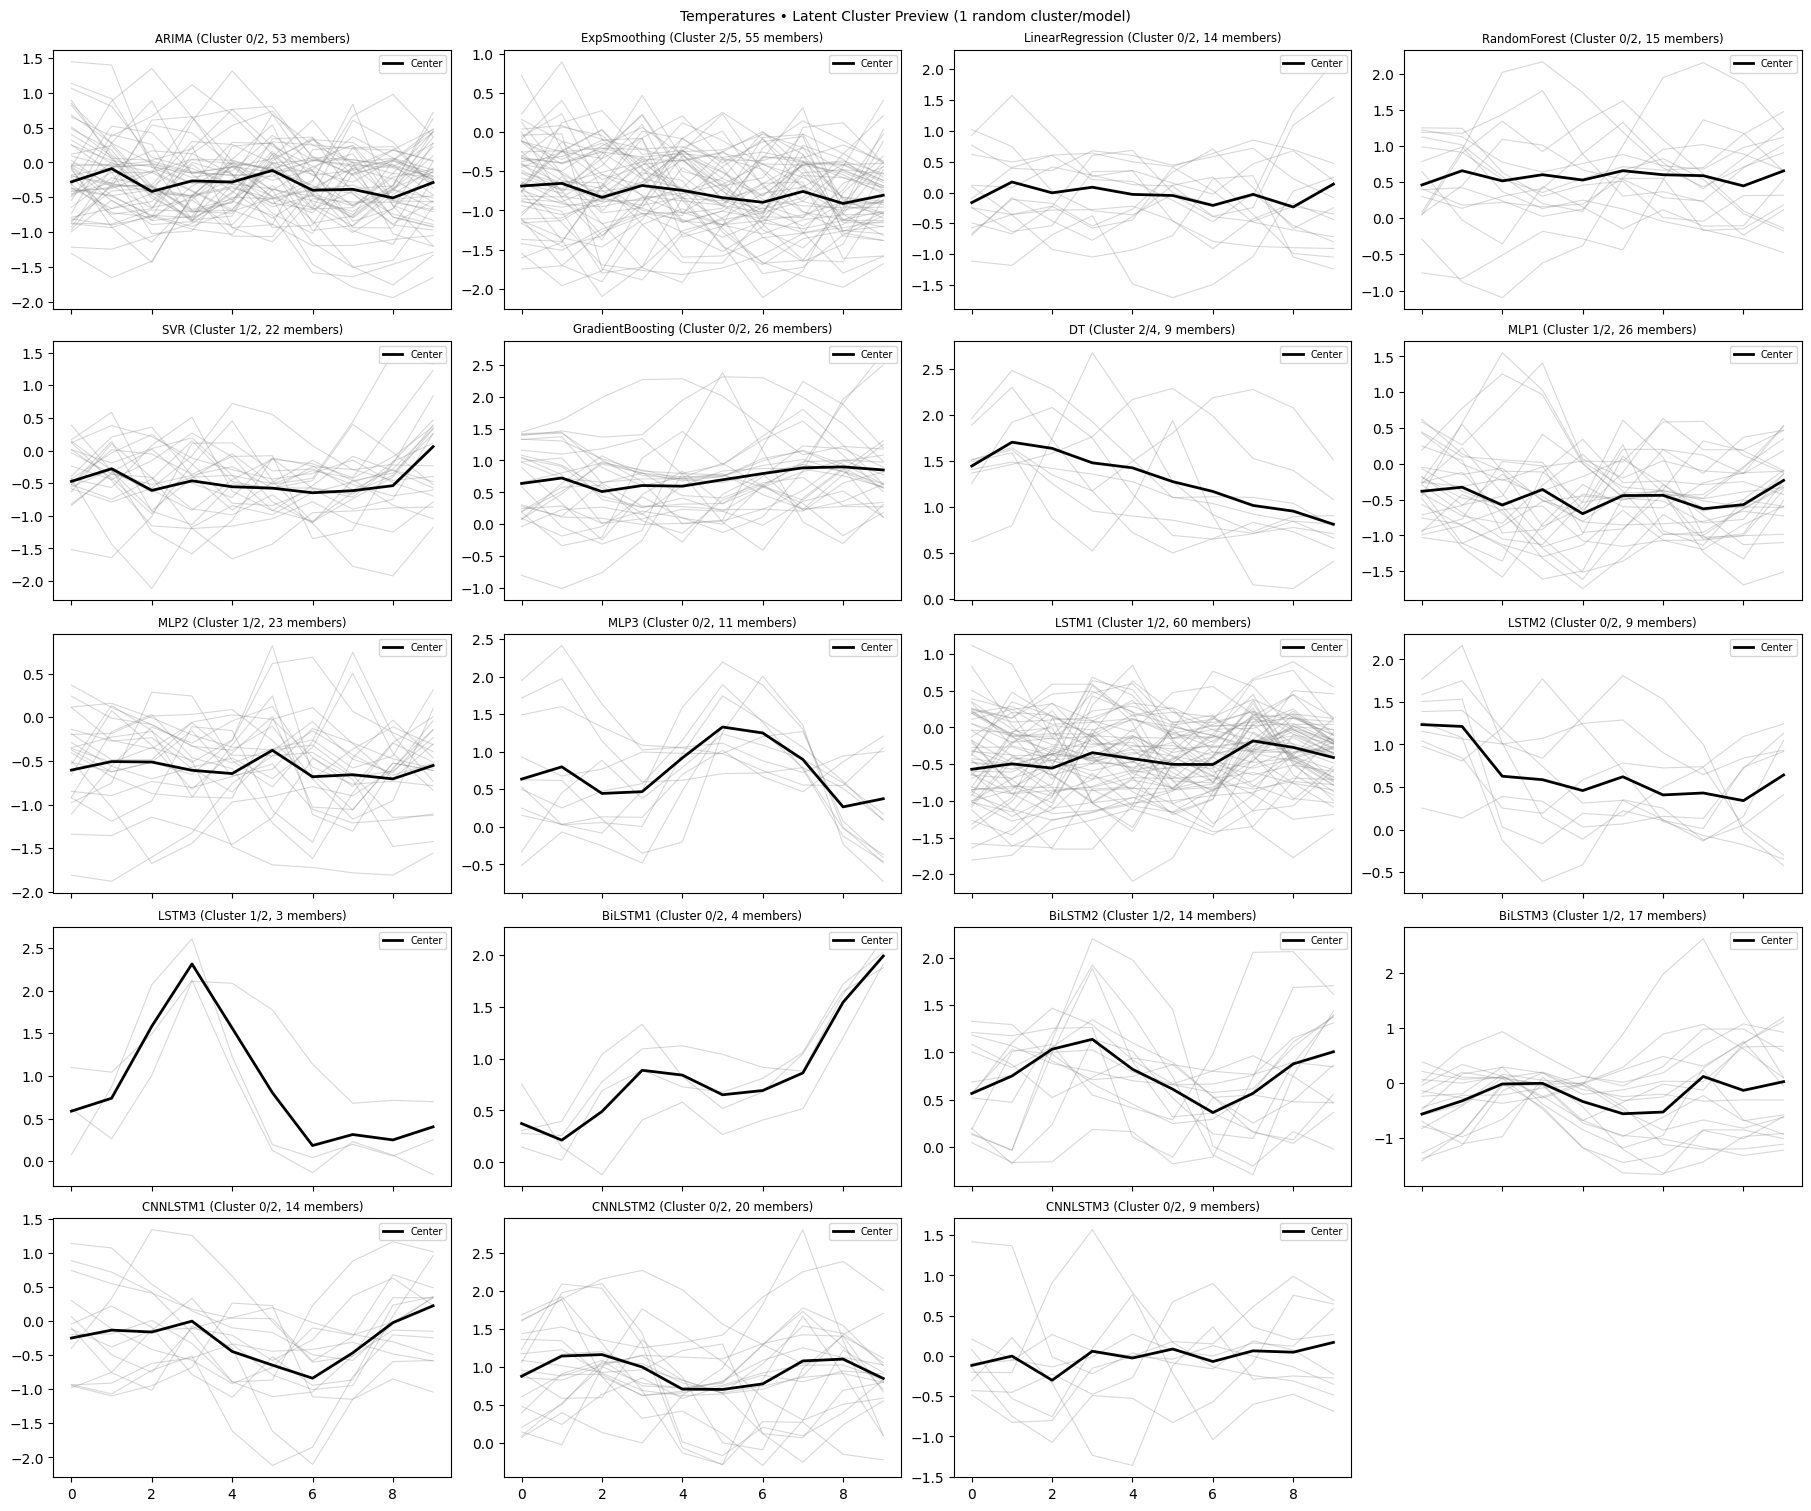

In [9]:
n_cols = 4
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Plot latent cluster samples for {ds_name} (compact grid) ===")

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    decoder_device = next(ae.decoder.parameters()).device

    valid_models = []
    for name, model in forecasters.items():
        centers = model.centers["latent"]
        windows = model.rocs["latent"]

        if len(centers) == 0 or len(windows) == 0:
            continue

        # Flatten latent windows
        X = np.vstack([
            (w.detach().cpu().numpy() if isinstance(w, torch.Tensor) else np.array(w)).flatten()
            for w in windows
        ])

        # Flatten latent centers
        C = np.vstack([
            (c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else np.array(c)).flatten()
            for c in centers
        ])

        # Use KMeans.predict with existing centers
        km = KMeans(n_clusters=len(C), init=C, n_init=1, max_iter=1, random_state=seed)
        labels = km.fit_predict(X)

        # Group windows by cluster
        cluster_to_indices = {i: [] for i in range(len(C))}
        for idx, label in enumerate(labels):
            cluster_to_indices[label].append(idx)

        valid_models.append((name, model, centers, cluster_to_indices, windows))

    n_models = len(valid_models)
    if n_models == 0:
        print(" No valid models to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, (name, model, centers, cluster_to_indices, windows) in zip(axes, valid_models):
        non_empty_clusters = [i for i, idxs in cluster_to_indices.items() if len(idxs) > 0]
        if not non_empty_clusters:
            ax.set_title(f"{name} (no populated clusters)", fontsize="small")
            ax.axis("off")
            continue

        chosen_c = random.choice(non_empty_clusters)
        member_indices = cluster_to_indices[chosen_c]

        for i in member_indices:
            w_tensor = windows[i].unsqueeze(0).to(decoder_device)
            decoded = ae.decoder(w_tensor).detach().cpu().numpy().flatten()
            ax.plot(decoded, alpha=0.3, linewidth=0.8, color='gray')

        c_tensor = centers[chosen_c].unsqueeze(0).to(decoder_device)
        decoded_center = ae.decoder(c_tensor).detach().cpu().numpy().flatten()
        ax.plot(decoded_center, color='black', linewidth=2, label="Center")

        ax.set_title(
            f"{name} (Cluster {chosen_c}/{len(centers)}, {len(member_indices)} members)",
            fontsize="small"
        )
        ax.legend(loc="upper right", fontsize="x-small")

    # Turn off unused axes
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent Cluster Preview (1 random cluster/model)",
                 fontsize="medium")
    plt.show()

In [10]:
def retrain_autoencoder(X, ds_name, batch_size=128):

    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()

    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X, dtype=torch.float).unsqueeze(1)),
        batch_size=batch_size,
        shuffle=True,
        generator=g
    )

    for epoch in range(1, epochs + 1):
        ae.train()
        losses = []
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon = ae(batch_x)
            loss = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)

    return ae.eval()

In [11]:
def rebuild_rocs(ae, forecasters, X, y, append=False):
    """
    Rebuilds or appends to each model's Region of Competence (RoC) based on validation data.
    """
    if not append:
        for model in forecasters.values():
            model.rocs["raw"].clear()
            model.rocs["latent"].clear()

    ae.eval()
    for idx, window in enumerate(X):
        errors = {
            name: mean_squared_error([y[idx]], [model.predict(window)])
            for name, model in forecasters.items()
        }
        winner = min(errors, key=errors.get)

        # Encode latent vector
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(window)
        forecasters[winner].rocs["latent"].append(latent_vec)

    return forecasters

> Bottleneck size: 2
> Detectors and parameters:
  None: None (no drift detection)
  ZScore: buffer_size=175, z_threshold=3.5, retain_fraction=0.1
  Percentile: buffer_size=200, percentile=98.5, retain_fraction=0.1
  HDDM_A: delta=0.0019
  HDDM_W: delta=0.009, alpha=0.85

=== Dataset: Births ===
[Metric: cosine] Detector: None       | MSE: 0.3635 | Time: 54.33s | Drifts: 0


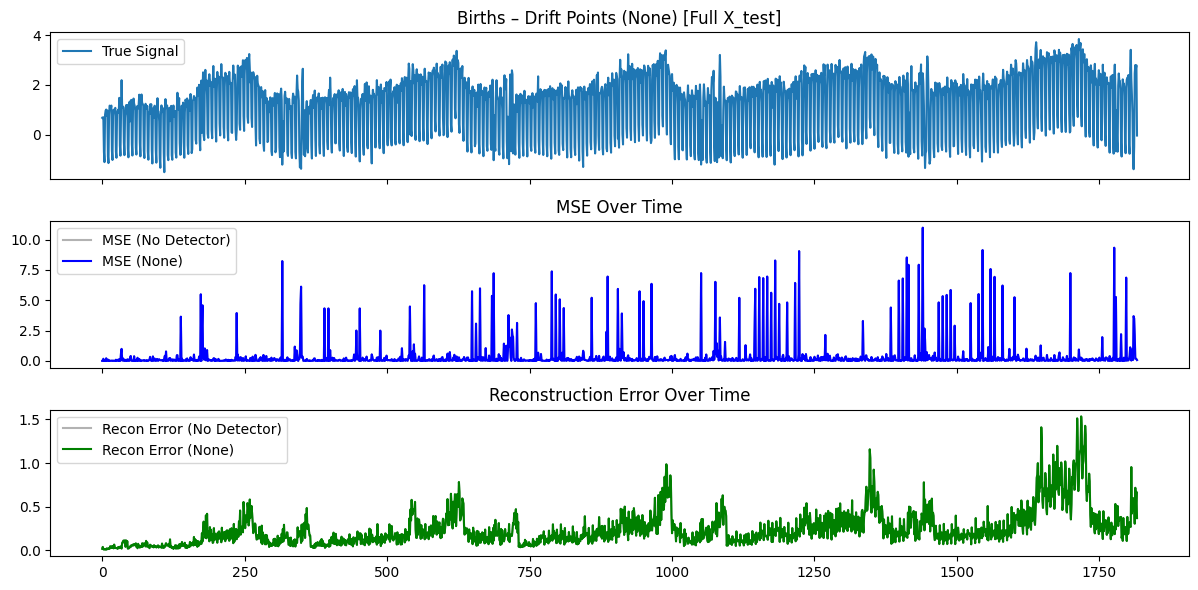

[Metric: cosine] Detector: ZScore     | MSE: 0.3358 | Time: 326.95s | Drifts: 6


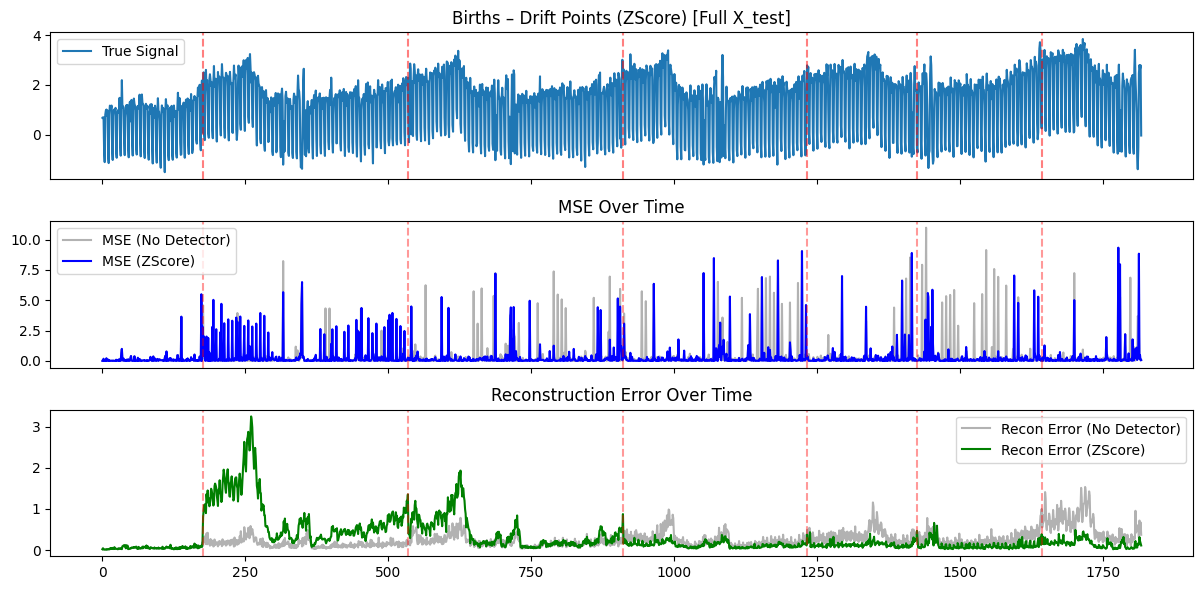

[Metric: cosine] Detector: Percentile | MSE: 0.2801 | Time: 318.78s | Drifts: 6


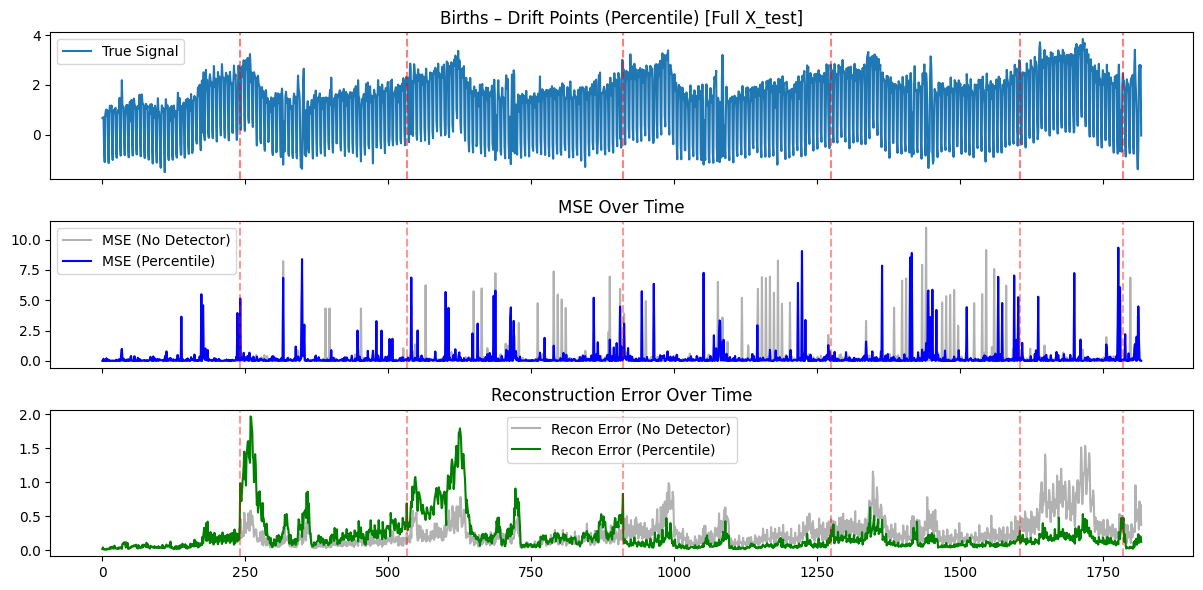

[Metric: cosine] Detector: HDDM_A     | MSE: 0.2576 | Time: 591.85s | Drifts: 12


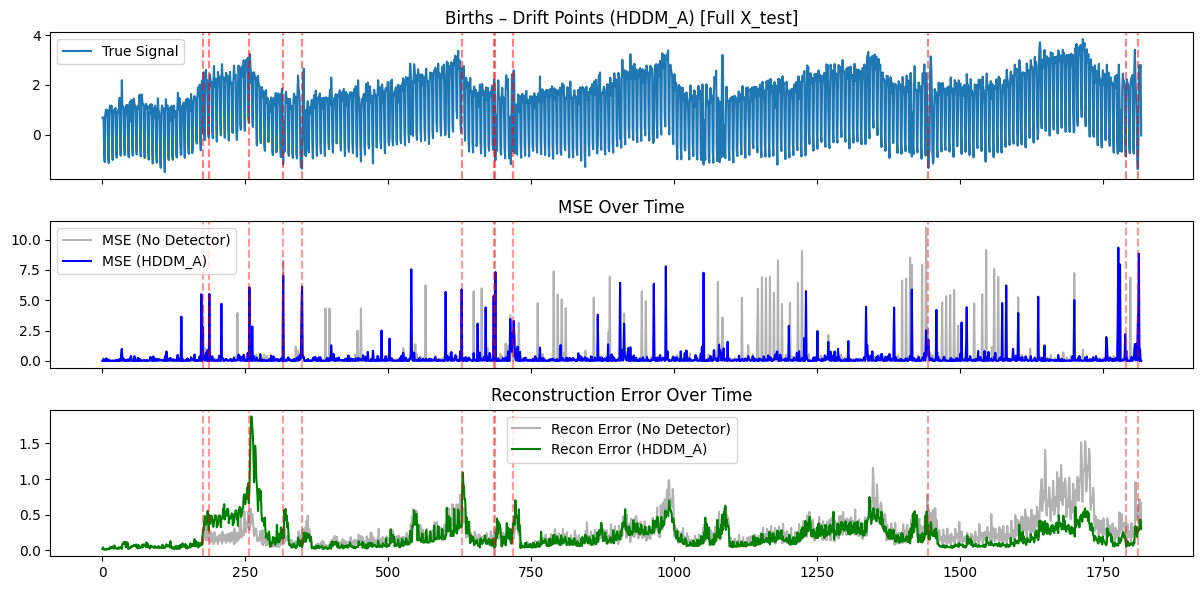

[Metric: cosine] Detector: HDDM_W     | MSE: 0.3327 | Time: 325.59s | Drifts: 6


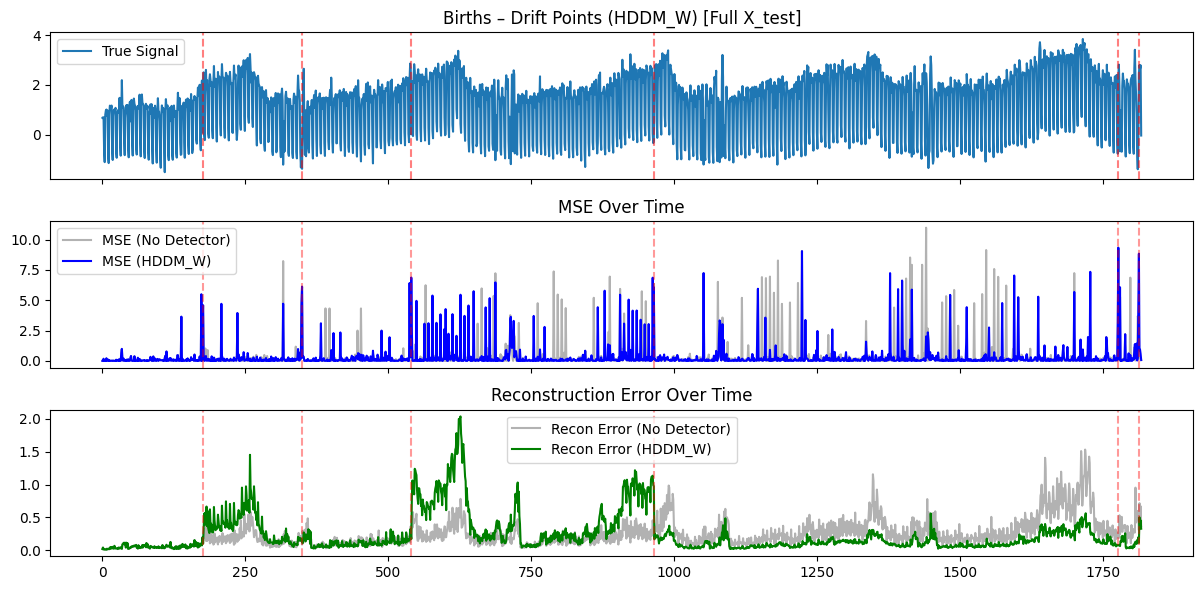


=== Dataset: Temperatures ===
[Metric: cosine] Detector: None       | MSE: 0.3470 | Time: 16.28s | Drifts: 0


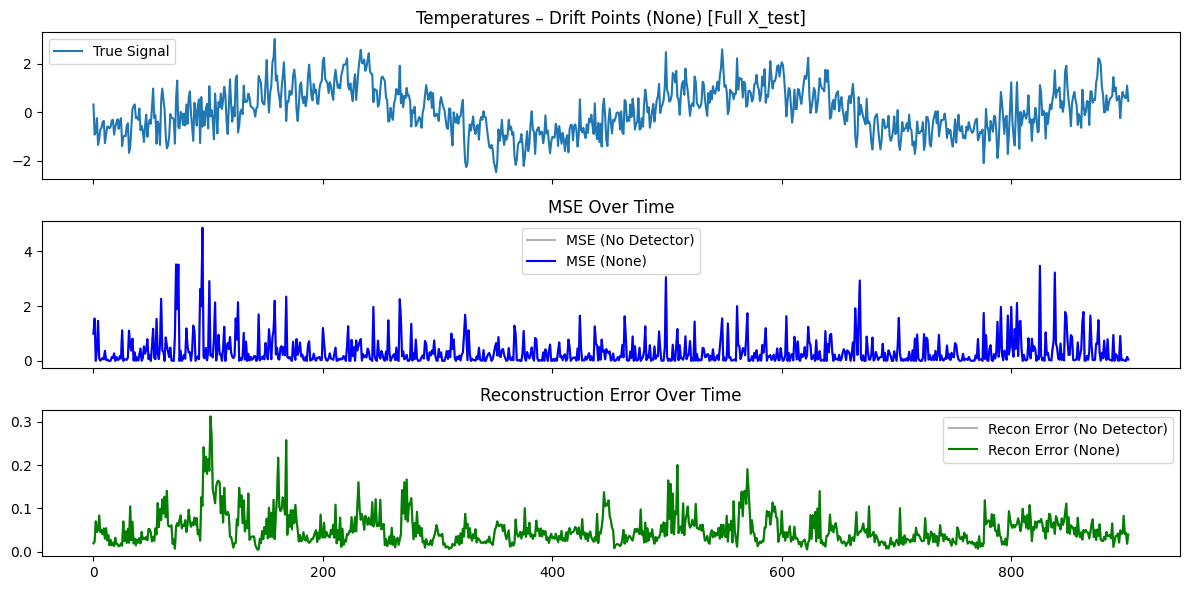

[Metric: cosine] Detector: ZScore     | MSE: 0.3445 | Time: 64.95s | Drifts: 2


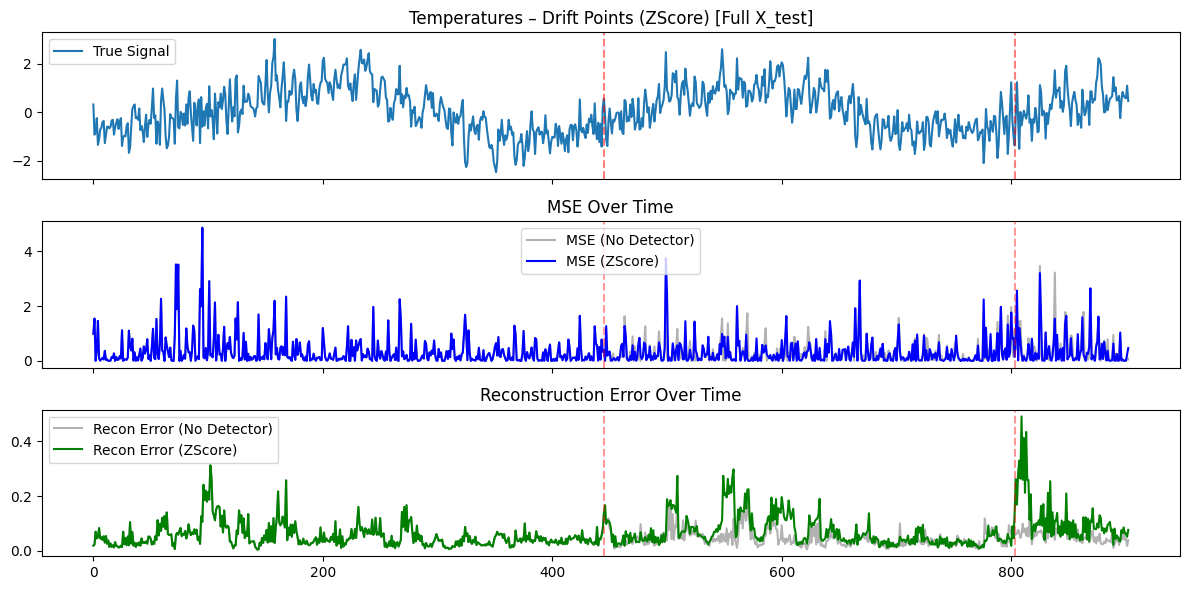

[Metric: cosine] Detector: Percentile | MSE: 0.3394 | Time: 60.50s | Drifts: 2


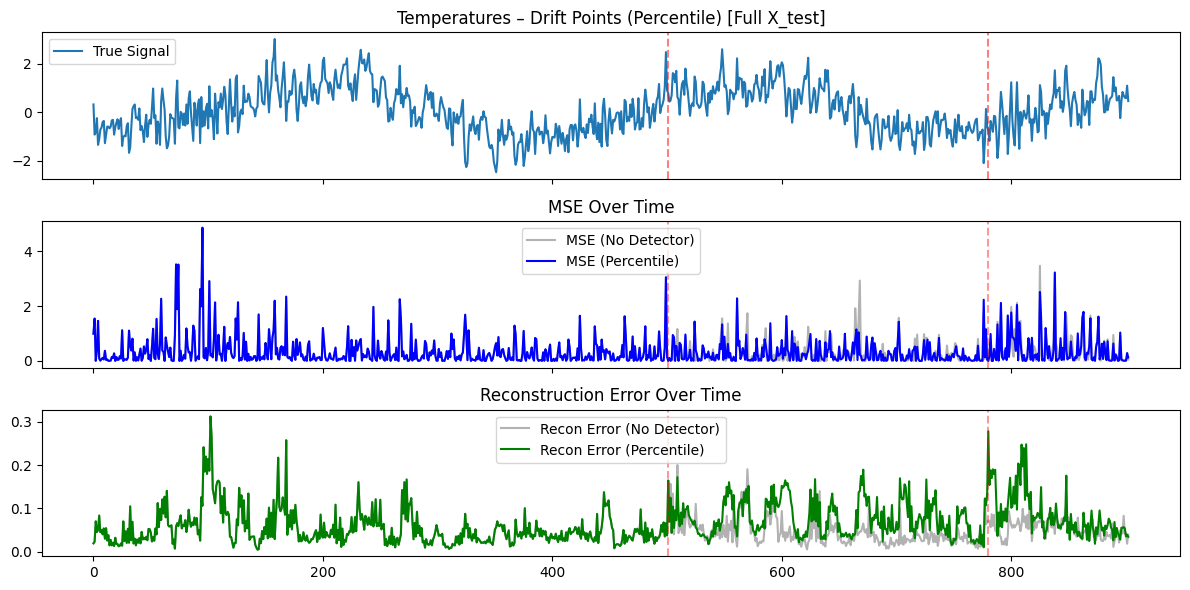

[Metric: cosine] Detector: HDDM_A     | MSE: 0.3336 | Time: 38.73s | Drifts: 1


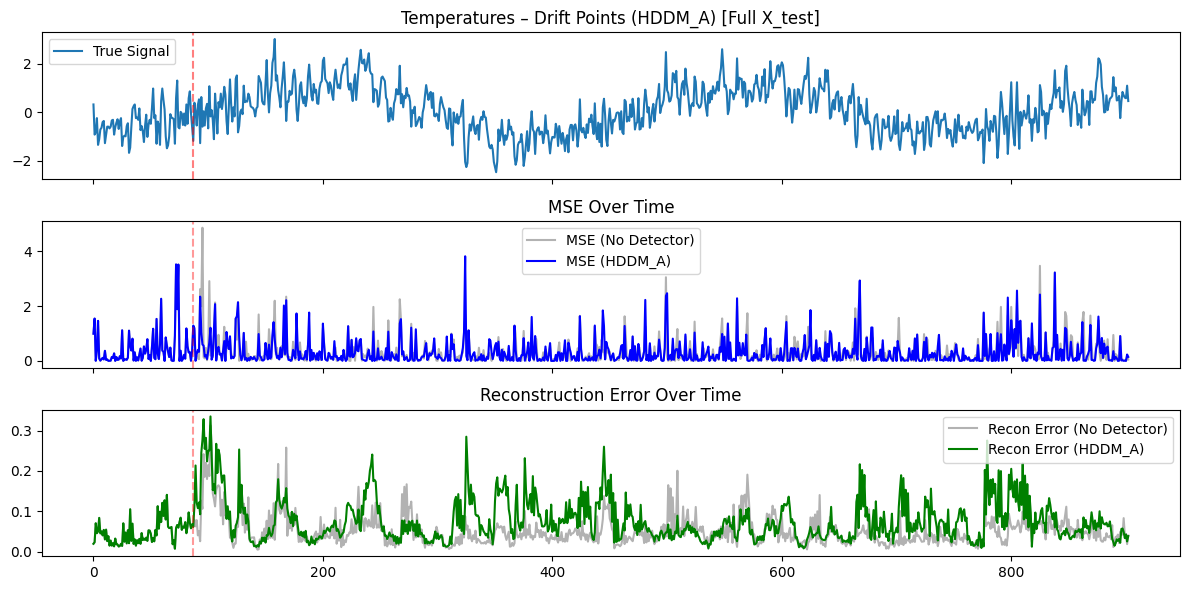

[Metric: cosine] Detector: HDDM_W     | MSE: 0.3470 | Time: 15.74s | Drifts: 0


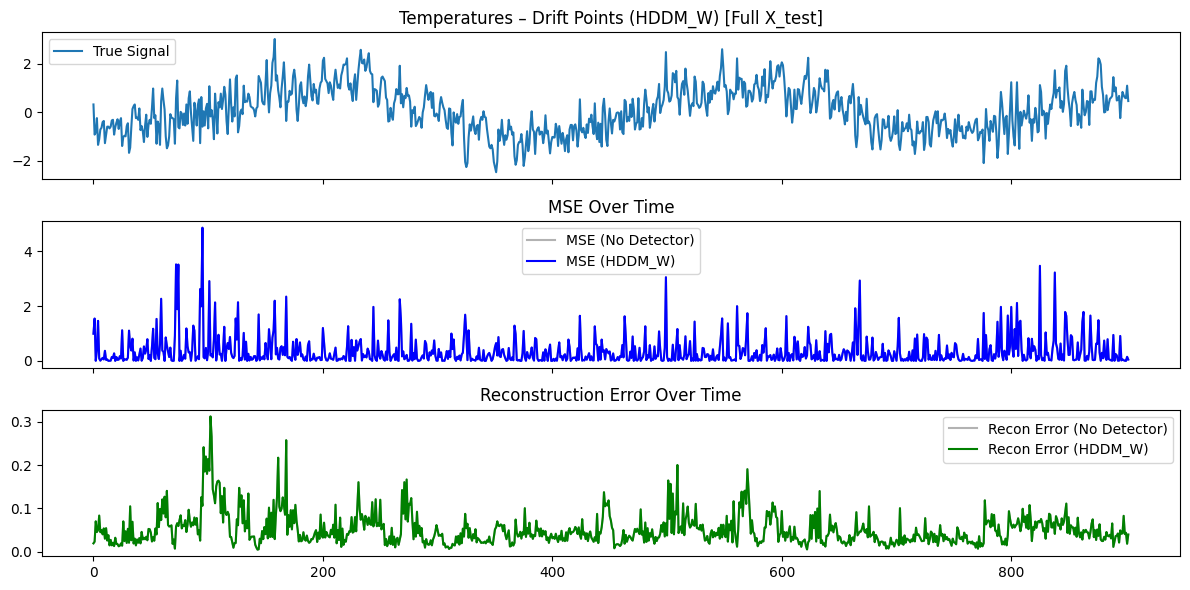

In [14]:
import copy

# Configurable parameters
recent_n_windows_ratio = 0.5
percentage = 0.5
append = False
metric = "cosine"

detector_classes = {
    "None":        None,
    "ZScore":      lambda: ZScoreReconstructionDriftDetector(buffer_size=175, z_threshold=3.5, retain_fraction=0.1),
    "Percentile":  lambda: PercentileReconstructionDriftDetector(buffer_size=200, percentile=98.5, retain_fraction=0.1),
    "HDDM_A":      lambda: HDDM_A_Detector(delta=0.0019), #18
    "HDDM_W":      lambda: HDDM_W_Detector(delta=0.009, alpha=0.85), 
}

print(f"> Bottleneck size: {latent_dim}")

print("> Detectors and parameters:")
relevant_keys = {
    "ZScore": ["buffer_size", "z_threshold", "retain_fraction"],
    "Percentile": ["buffer_size", "percentile", "retain_fraction"],
    "HDDM_A": ["delta"],
    "HDDM_W": ["delta", "alpha"],
}

for name, constructor in detector_classes.items():
    if constructor is None:
        print(f"  {name}: None (no drift detection)")
    else:
        instance = constructor()
        params = instance.__dict__
        keys_to_show = relevant_keys.get(name, [])
        param_str = ", ".join(f"{k}={params[k]}" for k in keys_to_show if k in params)
        print(f"  {name}: {param_str}")

baseline_mse_per_step = {}
baseline_recon_per_step = {}

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    n_windows = len(X_test)

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    for detector_name, DetectorClass in detector_classes.items():
        print(f"[Metric: {metric}] Detector: {detector_name:<10}", end=" | ")

        current_ae = ae
        current_forecasters = {name: copy.deepcopy(model) for name, model in forecasters.items()}
        detector = None if DetectorClass is None else DetectorClass()

        preds, y_trues, reconstruction_errors, mse_per_step = [], [], [], []

        t0 = time.perf_counter()
        for i, (window, y_true) in enumerate(zip(X_test, y_test)):
            with torch.no_grad():
                inp = torch.tensor(window, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
                latent = current_ae.encode(window).cpu()
                recon = current_ae(inp).cpu().squeeze().numpy()
            recon_error = mean_squared_error(window, recon)
            reconstruction_errors.append(recon_error)

            best_name, best_dist = None, float("inf")
            for name, model in current_forecasters.items():
                for entry in model.rocs["latent"]:
                    d = compute_distance(latent, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            y_pred = current_forecasters[best_name].predict(window)
            preds.append(y_pred)
            y_trues.append(y_true)
            mse_per_step.append((y_pred - y_true) ** 2)

            if detector is not None:
                drift_signal = (y_pred - y_true) ** 2 if "HDDM" in detector_name else recon_error
                if detector.update(drift_signal, i):
                    full_n_windows = len(X_train) + len(X_val) + len(X_test)
                    recent_n_windows = int(recent_n_windows_ratio * full_n_windows)
                    all_X = np.vstack([X_train, X_val, X_test])
                    all_y = np.concatenate([y_train, y_val, y_test])
                    test_offset = len(X_train) + len(X_val)
                    end_idx = test_offset + i
                    start_idx = max(0, end_idx - recent_n_windows)
                    X_recent = all_X[start_idx:end_idx]
                    y_recent = all_y[start_idx:end_idx]
                    cutoff = int(len(X_recent) * percentage)
                    current_ae = retrain_autoencoder(X_recent[:cutoff], ds_name)
                    rebuild_rocs(current_ae, current_forecasters, X_recent[cutoff:], y_recent[int(len(y_recent)*percentage):], append=append)

        elapsed = time.perf_counter() - t0
        mse = mean_squared_error(y_trues, preds)
        drift_count = 0 if detector is None else len(detector.get_drift_points())
        print(f"MSE: {mse:.4f} | Time: {elapsed:.2f}s | Drifts: {drift_count}")

        if detector_name == "None":
            baseline_mse_per_step[ds_name] = mse_per_step
            baseline_recon_per_step[ds_name] = reconstruction_errors

        drift_points = detector.get_drift_points() if detector is not None else []

        fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

        # Plot 1: True signal
        axs[0].plot(range(n_windows), y_test, label="True Signal")
        for idx in drift_points:
            axs[0].axvline(idx, color="red", linestyle="--", alpha=0.5)
        axs[0].set_title(f"{ds_name} – Drift Points ({detector_name}) [Full X_test]")
        axs[0].legend()

        # Plot 2: MSE over time
        axs[1].plot(baseline_mse_per_step.get(ds_name, []), label="MSE (No Detector)", color="gray", alpha=0.6)
        axs[1].plot(mse_per_step, label=f"MSE ({detector_name})", color="blue")
        for idx in drift_points:
            axs[1].axvline(idx, color="red", linestyle="--", alpha=0.4)
        axs[1].set_title("MSE Over Time")
        axs[1].legend()

        # Plot 3: Recon error over time
        axs[2].plot(baseline_recon_per_step.get(ds_name, []), label="Recon Error (No Detector)", color="gray", alpha=0.6)
        axs[2].plot(reconstruction_errors, label=f"Recon Error ({detector_name})", color="green")
        for idx in drift_points:
            axs[2].axvline(idx, color="red", linestyle="--", alpha=0.4)
        axs[2].set_title("Reconstruction Error Over Time")
        axs[2].legend()

        plt.tight_layout()
        plt.show()